# Gabriele Cimador SM3500523 - Assignment 2
The purpose of this assignment is: 
- Calculate the intrinsic dimension of the KMNIST dataset using the twoNN algorithm;
- Train an autoencoder which reduces the dimension of the data to the intrinsic dimension;
- Assess the correctness of the intrinsic dimension via a classifier; use the encoder part (freezed parameters) and a classification layer to classify the output of the encoder. If no information is lost, the classifier should be able to perform better than a random classifier (0.1 accuracy).

In [1]:
from dadapy import data
import torchvision
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from urllib.request import urlretrieve
from os.path import exists, isdir
from os import makedirs
from math import ceil

## Random seed setting
Let us set a manual seed to allow reproducibility of the experiment.

In [2]:
torch.manual_seed(0)

## Device selection
We will use GPUs if available to speed up the computations.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## The dataset
### Retrieving the dataset
We will retrieve the dataset if not present. The dataset is in Numpy format to use the twoNN algorithm.
The values of the dataset are shrinked from [0,255] to [0,1].

In [4]:
def fetch_kmnist(data_path = "kmnist", force_download = True):
    """Function that fetches the train and test kmnist dataset and returns it in a numpy array.
    It downloads it if the file is not present or if force_download is True."""
    
    url = 'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-'
    train_set_url = url + 'train-imgs.npz'
    test_set_url  = url + 'test-imgs.npz'
    train_labels_url = url + 'train-labels.npz'
    test_labels_url  = url + 'test-labels.npz'
    
    train_set_path = data_path + "/train_set"
    test_set_path  = data_path + "/test_set"
    train_labels_path = data_path + "/train_labels"
    test_labels_path = data_path + "/test_labels"
    
    if not isdir(data_path):
        makedirs(data_path)
    
    for path,url in [(train_set_path,train_set_url),(test_set_path,test_set_url),(train_labels_path,train_labels_url),(test_labels_path,test_labels_url)]:
        if not exists(path) or force_download:
            print(f"downloading data from {url} to {path}")
            urlretrieve(url, path)
       
    train_set = np.load(train_set_path)['arr_0'] / 255
    test_set  = np.load(test_set_path)['arr_0'] / 255
    train_labels = np.load(train_labels_path)['arr_0']
    test_labels  = np.load(test_labels_path)['arr_0']
    
    return train_set, test_set, train_labels, test_labels

In [5]:
train_set, test_set, train_labels, test_labels = fetch_kmnist(force_download = False)

### Data loaders
Now we obtain the PyTorch dataloaders from the Numpy datasets (batch size = 256)

In [6]:
def create_data_loaders(batch_size = 256):
    torch_train = torch.Tensor(train_set).view(-1, 1,28,28).float()
    torch_test  = torch.Tensor(test_set).view(-1,1,28,28).float()

    torch_train_set = TensorDataset(torch_train,torch.from_numpy(train_labels))
    train_dataloader = DataLoader(torch_train_set, batch_size=batch_size, shuffle=False)

    torch_test_set = TensorDataset(torch_test,torch.from_numpy(test_labels))
    test_dataloader = DataLoader(torch_test_set, batch_size=batch_size, shuffle=False)
    
    return train_dataloader,test_dataloader

train_dataloader,test_dataloader = create_data_loaders()

## Intrinsic dimension
Using the daday package we compute the intrinsic dimension of the KMNIST dataset

In [7]:
def compute_id_with_twoNN(dataset):
    _data = data.Data(dataset.reshape(-1,28*28))
    # estimate ID
    id_twoNN, _, r = _data.compute_id_2NN()
    return ceil(id_twoNN)

#id_twoNN = compute_id_with_twoNN(train_set)
id_twoNN = 21

## The autoencoder
The autoencoder is now created.
### The encoder
The encoder is composed of:
- Convolutional layer with 32 filters, kernel size=3, stride=1, padding=0
- ReLU
- Max pooling layer with kernel size=2
- Convolutional layer with 64 filters, kernel size=3, stride=2, padding=1
- ReLU
- Max pooling layer with kernel size=2, stride=1
- Flattening layer
- Linear layer with input size=6x6x64, output size=intrinsic dimension

### The decoder
The decoder is composed of:
- Linear layer with input size=intrinsic dimension, output size=64x8x8
- ReLU
- Unflattening layer to obtain [64x8x8] data
- Transpose Convolution with 32 filters, kernel size=2, stride=2, padding=1
- ReLU
- Transpose Convolution with 1 filter, kernel size=2, stride=2, padding=0
- Sigmoid


In [8]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2),
            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 2, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 1),
            torch.nn.Flatten(),
            torch.nn.Linear(6*6*64, id_twoNN)
        )
    
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(id_twoNN, 64*8*8),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, torch.Size([64, 8, 8])),
            torch.nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 2, stride = 2, padding = 1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels = 32, out_channels = 1, kernel_size = 2, stride = 2, padding = 0),
            torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [9]:
model = AE().to(device)

## Training the AE
To train the AE,  we use the Adam algorithm as optimizer and MSE as loss function. We use 20 epochs and evaluate the MSE between the original data (x) with the output (x_hat).

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss = torch.nn.MSELoss(reduction = 'sum')

Epoch 1 Training loss:73.2361572265625
Epoch 2 Training loss:39.59022415771484
Epoch 3 Training loss:34.010921057128904
Epoch 4 Training loss:31.773605200195313
Epoch 5 Training loss:30.336667944335936
Epoch 6 Training loss:29.29374910481771
Epoch 7 Training loss:28.47610675048828
Epoch 8 Training loss:27.808116796875
Epoch 9 Training loss:27.251543587239585
Epoch 10 Training loss:26.784878247070314
Epoch 11 Training loss:26.380995182291667
Epoch 12 Training loss:26.03357021484375
Epoch 13 Training loss:25.732458866373698
Epoch 14 Training loss:25.464848307291668
Epoch 15 Training loss:25.231950244140624
Epoch 16 Training loss:25.028907576497396
Epoch 17 Training loss:24.849646435546877
Epoch 18 Training loss:24.663962890625
Epoch 19 Training loss:24.489416874186198
Epoch 20 Training loss:24.32259092203776
Test set loss:29.379712573242188


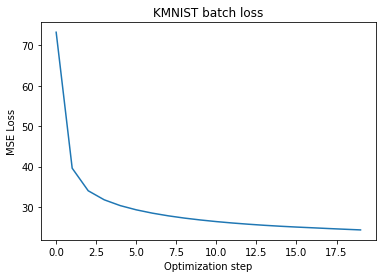

In [11]:
epochs = 20
losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x,_ in iter(train_dataloader):
        x=x.to(device)
        x_hat = model(x)
        l = loss(x_hat,x)
        train_loss += l.item()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    losses.append(train_loss / (len(train_dataloader.dataset)))
    print("Epoch "+ str(epoch+1) + " Training loss:" + str(train_loss / (len(train_dataloader.dataset))))
    
with torch.no_grad():
    model.eval()
    test_loss=0 
    for x,_ in iter(test_dataloader):
            x=x.to(device)
            x_hat=model(x)
            l=loss(x_hat,x)
            test_loss+=l.item()
    test_loss /= len(test_dataloader.dataset)
    print("Test set loss:"+str(test_loss))

plt.figure()
plt.title("KMNIST average batch loss")
plt.plot(losses)
plt.xlabel("Epoch")
_ = plt.ylabel("MSE Loss")

## Results
The intrinsic dimension computed seems to preserve the information contained in the original data. Let us see some outputs of the AE and compare them with the original image.

In [12]:
def display_images(input, output):
    if input is not None:
        input_pics = input.data.cpu().numpy().transpose((0,2,3,1))
        plt.figure(figsize=(18, 4))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(input_pics[i],cmap='gray')
    plt.figure(figsize=(18, 4))
    output_pics = output.data.cpu().numpy().transpose((0,2,3,1))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.imshow(output_pics[i],cmap='gray')

In [13]:
train_dataloader_view_only, test_dataloader_view_only = create_data_loaders(batch_size = 4)
x_train = next(iter(train_dataloader_view_only))[0].to(device)
x_test  = next(iter(test_dataloader_view_only))[0].to(device)

### Train images

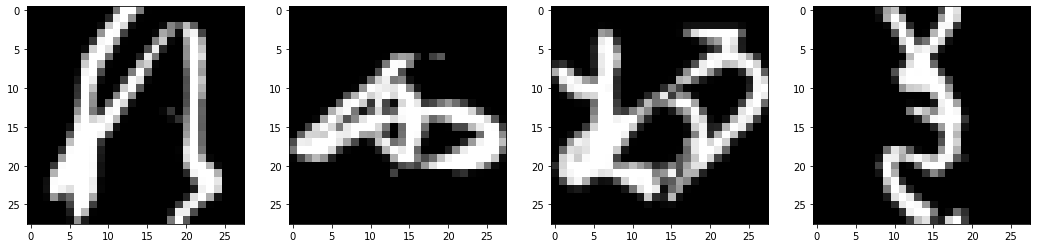

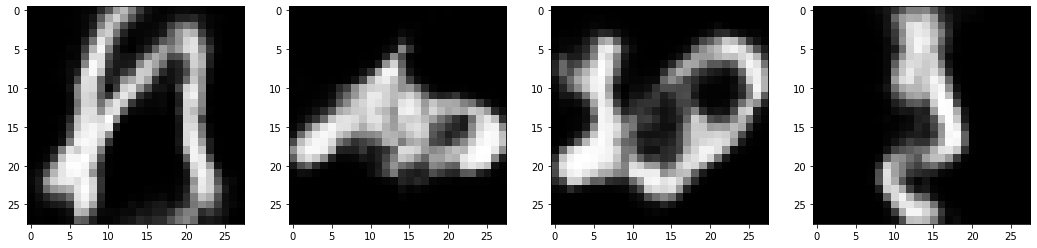

In [14]:
display_images(x_train,model(x_train))

### Test images

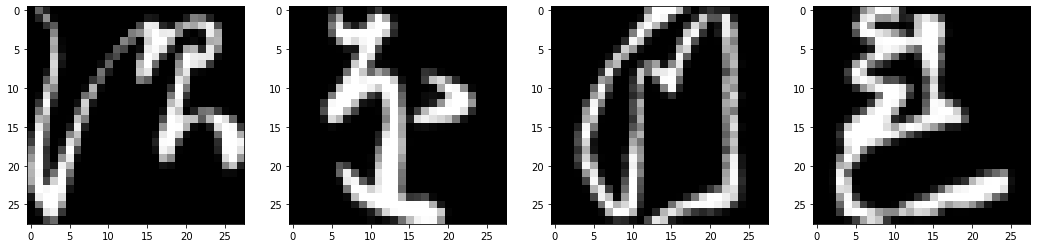

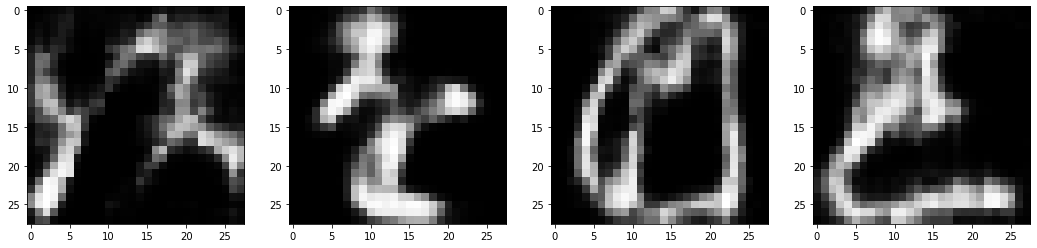

In [15]:
display_images(x_test,model(x_test))

## Assessment of the intrinsic dimension: a classifier
We will now use a classifier to check the truthfulness of the dimension computed by twoNN. We will use the encoded data and see if we are still able to classify them into the 10 classes. If the intrinsic dimension is correct, we will be able to get a better accuracy than 0.1, which is random classification.

### The classifier 
The classifier is composed of:
- The encoder of the previuous AE; its parameters are freezed
- A trainable fully connected layer with in_features=intrinsic dimension and out_features=10

In [16]:
class Classifier(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layer1 = model.encoder
        self.layer2 = torch.nn.Linear(in_features = id_twoNN, out_features = 10, bias = True)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.layer2(x)
        return x

In [17]:
classifier = Classifier().to(device)

### Freezing some parameters
Let us now freeze the parameters of the encoder so that only the final classification layer is trained.

In [18]:
for name,param in classifier.named_parameters():
    param.requires_grad = False if "layer1" in name else True

### Training the classifier
To train the classifier, we use the Adam algorithm as optimizer and Cross Entropy as loss function. We use 10 epochs and evaluate the accuracy between the original label (y) and the more probable class indicated by the classifier (out).

In [19]:
optimizer=torch.optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=1e-3)
loss=torch.nn.CrossEntropyLoss()

In [20]:
def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct=0
        for x, y in iter(dataloader):
            x=x.to(device)
            y=y.to(device)
            out=model(x)
            correct+=(torch.argmax(out, axis=1)==y).sum()
        return round(float(correct/len(dataloader.dataset)),4)

Test accuracy:  0.0974
Epoch:  0
Test accuracy:  0.4716
Epoch:  1
Test accuracy:  0.5668
Epoch:  2
Test accuracy:  0.5908
Epoch:  3
Test accuracy:  0.5989
Epoch:  4
Test accuracy:  0.6004
Epoch:  5
Test accuracy:  0.6016
Epoch:  6
Test accuracy:  0.6029
Epoch:  7
Test accuracy:  0.6033
Epoch:  8
Test accuracy:  0.6042
Epoch:  9
Final accuracy:  0.6047


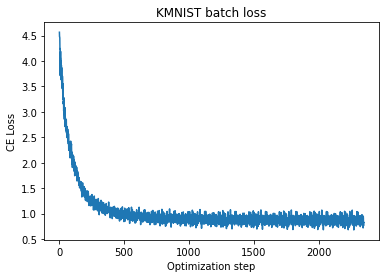

In [21]:
epochs=10
losses=[]
for epoch in range(epochs):
    print("Test accuracy: ", get_accuracy(classifier, test_dataloader))
    classifier.train()
    print("Epoch: ", epoch)
    for x, y in iter(train_dataloader):
        x=x.to(device)
        y=y.to(device)
        out=classifier(x)
        l=loss(out, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        losses.append(l.item())
print("Final accuracy: ", get_accuracy(classifier, test_dataloader))

plt.figure()
plt.title("KMNIST batch loss")
plt.plot(losses)
plt.xlabel("Optimization step")
_ = plt.ylabel("CE Loss")

## Conclusions
We are able to obtain an accuracy of 0.6 on the test set, which is far above than random classification. Even though the results are not perfect, we can conclude that the representation learned by the encoder using the intrinsic dimension is correct and preserves quite well the information.